<a href="https://colab.research.google.com/github/dsk2025/SEES-2024-Flooding-Model/blob/main/SEES_Flood_Tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [186]:
# Setup
import time
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import numpy as np
#!pip install rasterio
import rasterio
from scipy.ndimage import minimum_filter
from matplotlib.colors import LogNorm



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [187]:
# D8 direction encoding and decoding
D8_DIRECTIONS = {
    (0, 1):   1,    # East
    (1, 1):   2,    # Southeast
    (1, 0):   4,    # South
    (1, -1):  8,    # Southwest
    (0, -1):  16,   # West
    (-1, -1): 32,   # Northwest
    (-1, 0):  64,   # North
    (-1, 1):  128   # Northeast
}
# Directions are assuming the origin is at the top left of the raster and y increases downward
# (y,x) format matches index standard
DIRECTION_VECTORS = {v: k for k, v in D8_DIRECTIONS.items()}

In [188]:
def Read(tif_file):
    start_time = time.time()
    with rasterio.open(tif_file) as src:
        elevation = src.read(1)
        transform = src.transform # Gives the "affine" array that turns indexes into coordinates
        crs = src.crs # Identify the coordinate system

    # New array to store raster
    height, width = elevation.shape

    rows, cols = np.indices((height, width))
    lons, lats = transform * (cols, rows) # Apply affine transform on the matrix
    # We now have two more 2D arrays filled with indicies of columns/rows

    lon_diff = abs(transform[0])  # Pixel width
    lat_diff = abs(transform[4])  # Pixel height

    read_time = time.time() - start_time
    print(f"Reading DEM took {read_time:.2f} seconds")
    return elevation, lons, lats, lon_diff, lat_diff

In [189]:
def fill_sinks(elevation, lons, lats, lon_diff, lat_diff):
    # Define a kernel to check the 8 neighbors
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1], # Dont count itself
                       [1, 1, 1]])

    changes = True
    while changes:
        min_neighbors = minimum_filter(elevation, footprint=kernel, mode='constant', cval=np.inf) # Filter elevation array
        sinks = (elevation < min_neighbors) & (elevation != min_neighbors) # Compare elevation array to filtered array, creating boolean array
        sinks[:, 0] = sinks[:, -1] = sinks[0, :] = sinks[-1, :] = False # Exclude borders by setting them to False in the mask

        if not np.any(sinks):
            changes = False
        else:
            elevation[sinks] = min_neighbors[sinks] # Replace original array entry with filtered one if the filtered value is lower than the original

    return elevation # Filtered DEM raster



In [190]:
def D8(elevation):
    start_time = time.time()
    rows, cols = elevation.shape
    directions_grid = np.zeros((rows, cols), dtype=np.uint8)

    offsets = list(D8_DIRECTIONS.keys())
    direction_values = list(D8_DIRECTIONS.values())
    slopes = np.zeros((rows, cols, len(offsets)))
    hypotenuses = np.array([np.hypot(dy, dx) for dy, dx in D8_DIRECTIONS.keys()])


    for i, (dy, dx) in enumerate(offsets):

      shifted_elevation = np.roll(elevation, (-dy,-dx), axis=(0,1))

      if dy > 0:
          shifted_elevation[-1, :] = 999999 # Dirty way to work around np.roll for border conditions
      elif dy < 0:
          shifted_elevation[0, :] = 999999
      if dx > 0:
          shifted_elevation[:, -1] = 999999
      elif dx < 0:
          shifted_elevation[:, 0] = 999999
      slopes[...,i] = (elevation - shifted_elevation) / hypotenuses[i]

    max_slopes = np.amax(slopes, axis=2)

    for i, (dy, dx) in enumerate(offsets):
        directions_grid[slopes[..., i] == max_slopes] += direction_values[i]

    # Set cells with all negative slopes to 0 to retain original value in case of a sink
    directions_grid[max_slopes <= 0] = 0

    read_time = time.time() - start_time
    print(f"D8 took {read_time:.2f} seconds")
    return directions_grid

In [191]:
def flow_accumulation(directions_grid):
    rows, cols = directions_grid.shape
    flow_acc = np.zeros_like(directions_grid, dtype=np.int32)
    reverse_directions = {
        1: 16,   # East -> West
        2: 32,   # Southeast -> Northwest
        4: 64,   # South -> North
        8: 128,  # Southwest -> Northeast
        16: 1,   # West -> East
        32: 2,   # Northwest -> Southeast
        64: 4,   # North -> South
        128: 8   # Northeast -> Southwest
    }

    def process_cell(y, x):
        if flow_acc[y, x] > 0:
            return flow_acc[y, x]

        flow_acc[y, x] = 1  # Start with 0 to count the cell itself

        for (dy, dx), code in D8_DIRECTIONS.items():
            ny, nx = y + dy, x + dx
            if 0 <= ny < rows and 0 <= nx < cols and ((directions_grid[ny, nx] & reverse_directions[code]) == reverse_directions[code]):
                flow_acc[y, x] += process_cell(ny, nx)

        return flow_acc[y, x]

    for y in range(rows):
        for x in range(cols):
            if flow_acc[y, x] == 0:
                process_cell(y, x)

    flow_acc -= 1
    # Adjust to not count the cell itself
    return flow_acc

# Example usage
elevation = np.array([
    [10,  5, 11],
    [11, 10,  5],
    [10,  9, 10],
])

raster = D8(elevation)
print("D8 Raster:")
print(raster)
flow_acc = flow_accumulation(raster)
print("Flow Accumulation:")
print(flow_acc)
print (128 & 64)

D8 took 0.00 seconds
D8 Raster:
[[  1   0  20]
 [128  65   0]
 [  1 128  64]]
Flow Accumulation:
[[0 4 0]
 [0 0 5]
 [0 1 0]]
0


In [192]:
# Imshow to visualize data
def Plot (elevation, filled_elevation, directions_grid, flow_acc, lons, lats):

  # Plot elevation
  plt.figure(figsize=(10, 10))
  # Use LogNorm for logarithmic color scale
  plt.imshow(elevation, cmap='terrain', extent=(lons.min(), lons.max(), lats.min(), lats.max()))
  plt.title('Elevation')
  plt.colorbar()
  plt.show()

  # Plot filled DEM
  plt.figure(figsize=(10, 10))
  plt.imshow(filled_elevation, cmap='terrain', extent=(lons.min(), lons.max(), lats.min(), lats.max()))
  plt.colorbar(label='Elevation')
  plt.title('Filled DEM')
  plt.show()

  # Plot directions
  plt.figure(figsize=(10, 10))
  plt.imshow(directions_grid, cmap='Set1',norm=LogNorm(),extent=(lons.min(), lons.max(), lats.min(), lats.max()))
  plt.colorbar()
  plt.title('D8 Flow Directions')
  plt.show()

  # Plot accumulation
  plt.figure(figsize=(10, 10)) # Logarthmic
  plt.imshow(flow_acc,norm=LogNorm(),extent=(lons.min(), lons.max(), lats.min(), lats.max()))
  plt.colorbar()
  plt.title('Flow Accumulation (Logarithmic)')
  plt.show()

  plt.figure(figsize=(10, 10)) # Linear
  plt.imshow(flow_acc,extent=(lons.min(), lons.max(), lats.min(), lats.max()))
  plt.colorbar()
  plt.title('Flow Accumulation (Linear)')
  plt.show()




Reading DEM took 0.02 seconds
D8 took 0.03 seconds


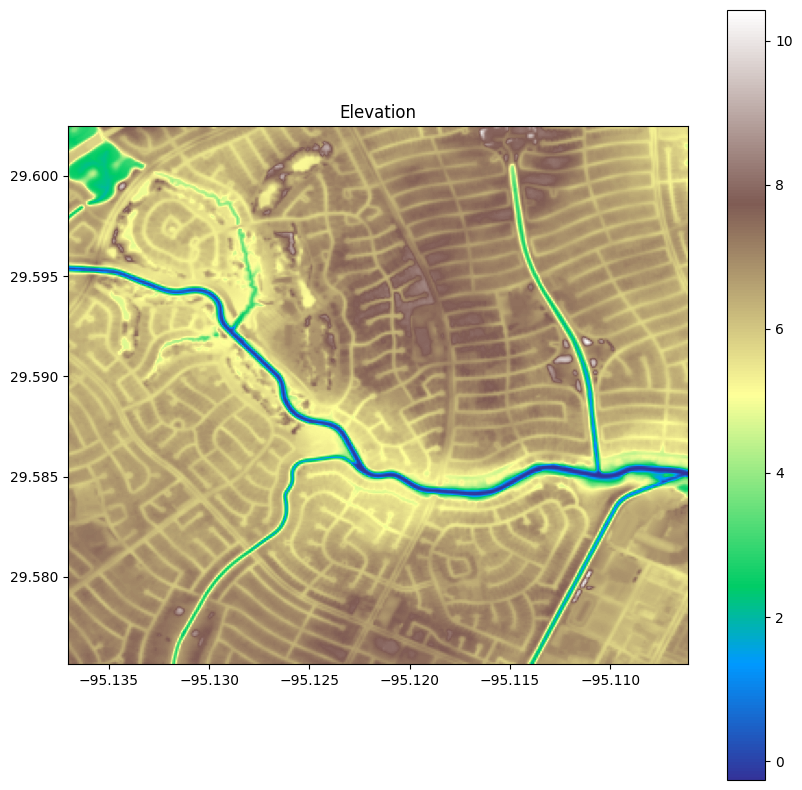

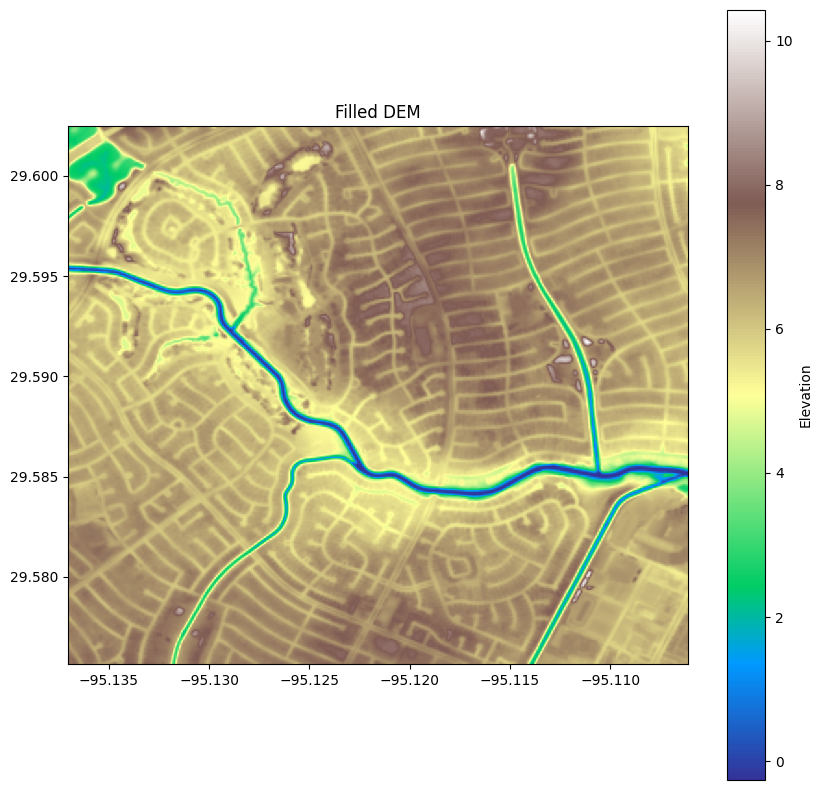

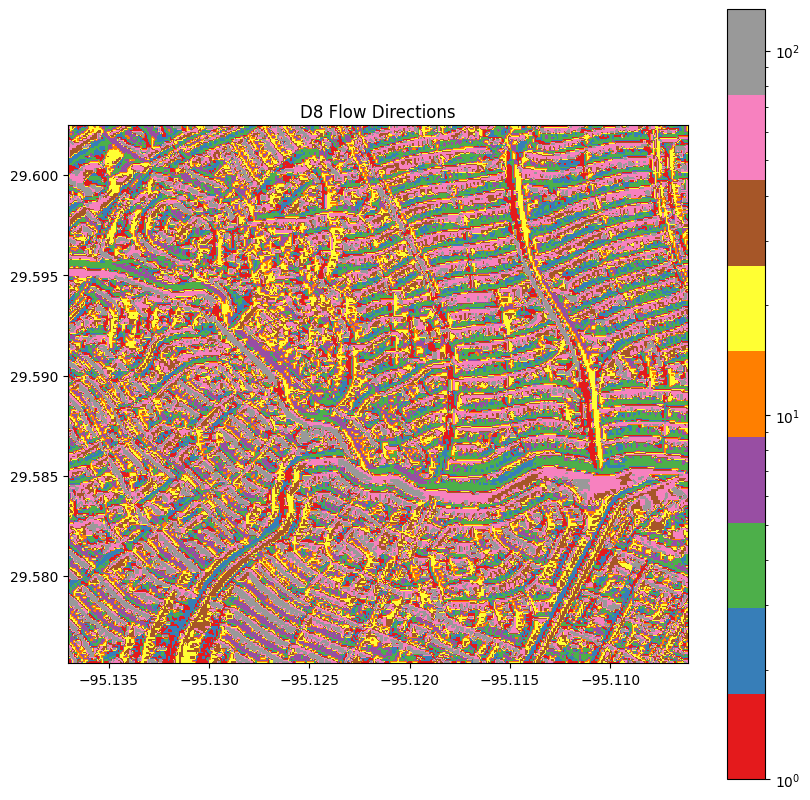

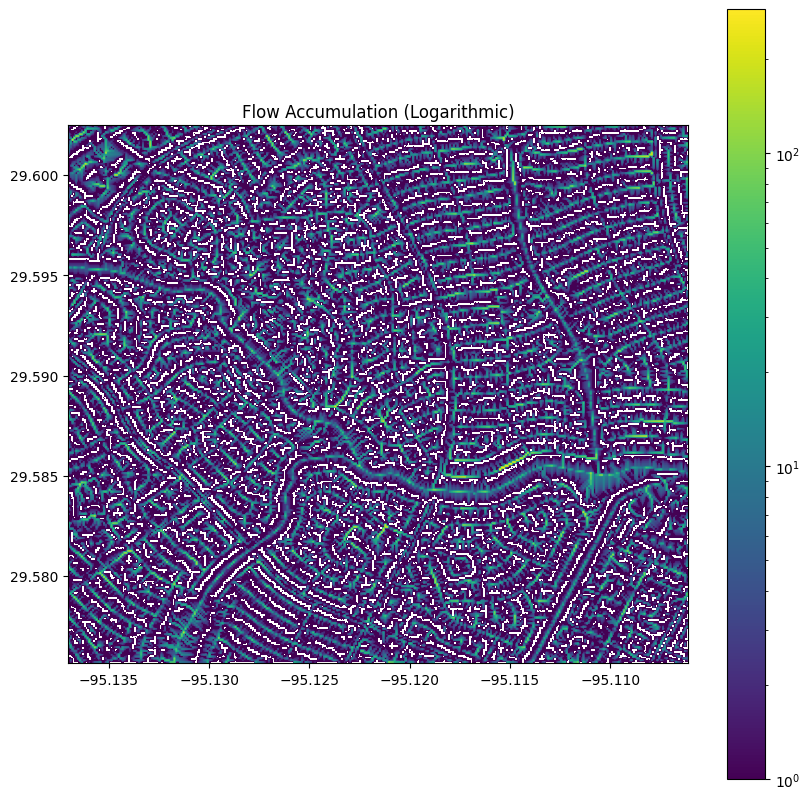

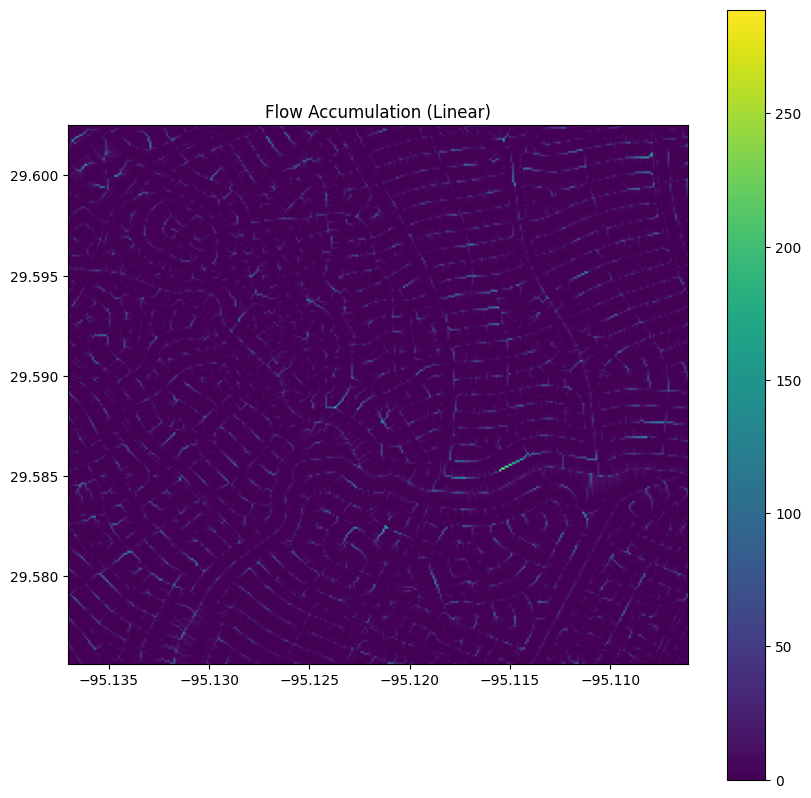

In [193]:
def main(tif_file):
    elevation, lons, lats, lon_diff, lat_diff = Read(tif_file)
    filled_elevation = fill_sinks(elevation, lons, lats, lon_diff, lat_diff)
    directions_grid = D8(filled_elevation)
    flow_acc = flow_accumulation(directions_grid)
    Plot(elevation, filled_elevation, directions_grid, flow_acc, lons, lats)
    #plot_results(filled_elevation, directions_grid, flow_acc, lons, lats, lon_diff, lat_diff)

# Run the main function
tif_file = '/content/drive/MyDrive/Houston AOI TIFs/AOI3.tif'
main(tif_file)


In [194]:
def plot_results(elevation, directions_grid, accumulation_grid, lons, lats, lon_diff, lat_diff):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    x_min, x_max = lons.min() - lon_diff / 2, lons.max() + lon_diff / 2
    y_min, y_max = lats.min() - lat_diff / 2, lats.max() + lat_diff / 2

    axs[0].set_xlim(x_min, x_max)
    axs[0].set_ylim(y_min, y_max)
    axs[0].set_xticks(np.arange(x_min, x_max + lon_diff, lon_diff))
    axs[0].set_yticks(np.arange(y_min, y_max + lat_diff, lat_diff))
    axs[0].grid(True)
    axs[0].set_title('Direction Codes')

    axs[1].set_xlim(x_min, x_max)
    axs[1].set_ylim(y_min, y_max)
    axs[1].set_xticks(np.arange(x_min, x_max + lon_diff, lon_diff))
    axs[1].set_yticks(np.arange(y_min, y_max + lat_diff, lat_diff))
    axs[1].grid(True)
    axs[1].set_title('Flow Accumulation')

    for i in range(lons.shape[0]):
        for j in range(lons.shape[1]):
            xi, yi = lons[i, j], lats[i, j]
            direction_code = directions_grid[i, j]
            elevation_value = elevation[i, j]
            accumulation_value = accumulation_grid[i, j]

            # Plot direction codes
            axs[0].text(xi, yi, str(direction_code), ha='center', va='center', fontsize=30)
            if direction_code != 0:
                for code, vector in DIRECTION_VECTORS.items():
                    if direction_code & code:
                        dx, dy = vector
                        axs[0].arrow(xi, yi, dy * lon_diff * .4, -dx * lat_diff * .4, head_width=lon_diff * 0.1, head_length=lat_diff * 0.1, fc='red', ec='red')

            # Plot steepest descent arrows
            axs[1].text(xi, yi, str(accumulation_value), ha='center', va='center', fontsize=30)
            if direction_code != 0:
                for code, vector in DIRECTION_VECTORS.items():
                    if direction_code & code:
                        dx, dy = vector
                        #axs[1].arrow(xi, yi, dy * lon_diff * 0.4, -dx * lat_diff * 0.4, head_width=lon_diff * 0.2, head_length=lat_diff * 0.1, fc='red', ec='red')


    plt.show()

In [195]:
"""# Trace flow off one pixel
def trace_water_flow(start_lon, start_lat, directions_grid, lon_diff, lat_diff):
    path = [(start_lon, start_lat)]  # Initialize path
    current_lon, current_lat = start_lon, start_lat

    while True:
        direction_code = directions_grid.get((current_lon, current_lat), 0)
        if direction_code == 0:
            break

        next_step = None
        for code, vector in DIRECTION_VECTORS.items():
            if direction_code & code:
                next_step = vector
                break

        if next_step is None:
            break

        dx, dy = next_step
        next_lon = current_lon + dx * lon_diff
        next_lat = current_lat + dy * lat_diff

        if (next_lon, next_lat) in directions_grid:
            current_lon, current_lat = next_lon, next_lat
            path.append((current_lon, current_lat))
        else:
            break

    return path"""

'# Trace flow off one pixel\ndef trace_water_flow(start_lon, start_lat, directions_grid, lon_diff, lat_diff):\n    path = [(start_lon, start_lat)]  # Initialize path\n    current_lon, current_lat = start_lon, start_lat\n\n    while True:\n        direction_code = directions_grid.get((current_lon, current_lat), 0)\n        if direction_code == 0:\n            break\n\n        next_step = None\n        for code, vector in DIRECTION_VECTORS.items():\n            if direction_code & code:\n                next_step = vector\n                break\n\n        if next_step is None:\n            break\n\n        dx, dy = next_step\n        next_lon = current_lon + dx * lon_diff\n        next_lat = current_lat + dy * lat_diff\n\n        if (next_lon, next_lat) in directions_grid:\n            current_lon, current_lat = next_lon, next_lat\n            path.append((current_lon, current_lat))\n        else:\n            break\n\n    return path'